# 🧠 PyTorch Workflow
---
This notebook provides a comprehensive introduction to **PyTorch**, covering essential topics, theory, functions, and practical examples. 

📘 **Official Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

📘 **Official Pytorch Cheatsheet**: [https://docs.pytorch.org/tutorials/beginner/ptcheat.html](https://docs.pytorch.org/tutorials/beginner/ptcheat.html)

📘 **Notebook Resource**: [https://www.learnpytorch.io/02_pytorch_classification/](https://www.learnpytorch.io/02_pytorch_classification/)

---

## 📑 Contents
1. Preparing Dataset
2. Visualize Data
3. Split Dataset
4. Build Model
5. Loss Functions
6. Optimization
7. Building Training Loop
8. Building Testing Loop
9. Training
10. Evaluation
11. Saving and Loading Model
12. Summary (Whole process on GPU)


# Preparing Dateset

In [129]:
import sklearn

from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles

X,y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42,
                    )


In [130]:
len(X), len(y)

(1000, 1000)

In [131]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [132]:
# Make Dataframe of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label" : y })
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


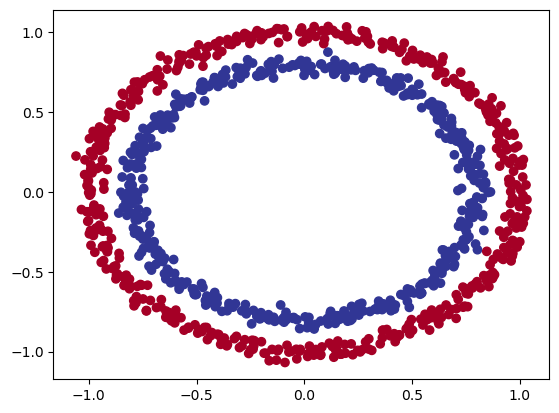

In [133]:
# Visualize data

import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu,)

In [134]:
# Check Shapes
X.shape , y.shape

((1000, 2), (1000,))

In [135]:
X_sample = X[0]
y_sample = y[0]

print(f"Value for one sample of X: {X[0]} and for y: {y[0]}")
print(f"Value for one sample of X: {X[0].shape} and for y: {y[0].shape}")

Value for one sample of X: [0.75424625 0.23148074] and for y: 1
Value for one sample of X: (2,) and for y: ()


## Turn data into Tensors

In [136]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [137]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

## Split data into train and test sets

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size = 0.2, # 20 percent for test
                                                     random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building Model

1. Device agnostic code
2. Construct class (subclass `nn.module`)
3. Define loss funcition and optiimzer
4. Create training and test loop

In [139]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [140]:
# Transfer data into GPU (if available)

X_train = X_train.to(device) 
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Define Architecture of model
1. Subclass nn.Module
2. Create 2 nn.Linear()
3. Define a forward() method

In [141]:
import torch
from torch import nn

class CircleModelV0(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Define layers capable of handling input features of data shape
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))
    

# Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [142]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True)

## Using Sequential Model

In [143]:
# Replicate the model using sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device=device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [144]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [145]:
# Make predictions to see performance of model_0 without training

with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


## Loss Function and Optimizer

In [146]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)
 

In [147]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc



## Training and Testing Loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer

Model outputs will be logits which then will be send to a sigmoid (binary classification) or softmax (multi class classification) function to output probabilities.

In [148]:
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):

    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate Test loss and accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_test,
                               test_pred)
        
    # print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}  |   Loss: {loss:.5f}    |   Acc: {acc:.2f}%     | Test Loss: {test_loss:.5f}   | Test Accuracy: {test_acc:.2f}%')

Epoch: 0  |   Loss: 0.69796    |   Acc: 51.88%     | Test Loss: 0.69440   | Test Accuracy: 58.00%
Epoch: 10  |   Loss: 0.69590    |   Acc: 51.25%     | Test Loss: 0.69305   | Test Accuracy: 53.00%
Epoch: 20  |   Loss: 0.69490    |   Acc: 51.62%     | Test Loss: 0.69254   | Test Accuracy: 49.50%
Epoch: 30  |   Loss: 0.69435    |   Acc: 51.12%     | Test Loss: 0.69236   | Test Accuracy: 49.50%
Epoch: 40  |   Loss: 0.69401    |   Acc: 50.88%     | Test Loss: 0.69232   | Test Accuracy: 51.00%
Epoch: 50  |   Loss: 0.69378    |   Acc: 50.25%     | Test Loss: 0.69234   | Test Accuracy: 50.00%
Epoch: 60  |   Loss: 0.69362    |   Acc: 50.00%     | Test Loss: 0.69239   | Test Accuracy: 51.50%
Epoch: 70  |   Loss: 0.69351    |   Acc: 50.25%     | Test Loss: 0.69246   | Test Accuracy: 51.00%
Epoch: 80  |   Loss: 0.69342    |   Acc: 49.88%     | Test Loss: 0.69254   | Test Accuracy: 50.00%
Epoch: 90  |   Loss: 0.69336    |   Acc: 49.88%     | Test Loss: 0.69262   | Test Accuracy: 53.00%


### Plotting decision boundary through helper function

In [149]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

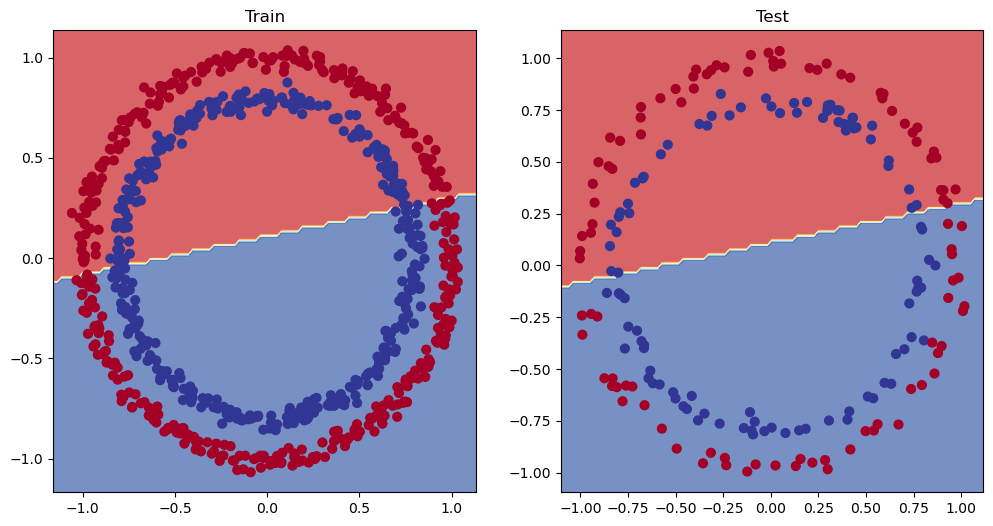

In [150]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


# Improving Model (from model perspective)

- Add more layers
- Add more hidden units
- Try more epochs
- Change activation functions
- Change learning rate
- Change loss function

In [151]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0849, -0.2762],
                      [ 0.4610, -0.5187],
                      [-0.3271, -0.1947],
                      [-0.4220,  0.0507],
                      [-0.7016,  0.6600]])),
             ('0.bias', tensor([-0.6060,  0.5246,  0.1149, -0.2211,  0.4275])),
             ('1.weight',
              tensor([[ 0.0741,  0.2406,  0.0222, -0.1075,  0.1965]])),
             ('1.bias', tensor([-0.1888]))])

### Let's improve the model by:
* Adding mroe hidden units: 5 -> 10
* Increase number of layers: 2 -> 3
* Increase number of epochs: 100 -> 1000

In [152]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelV1().to(device=device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [153]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                      [ 0.4082,  0.1265],
                      [ 0.3591, -0.4310],
                      [-0.7000, -0.2732],
                      [-0.5424,  0.5802],
                      [ 0.2037,  0.2929],
                      [ 0.2236, -0.0123],
                      [ 0.5534, -0.5024],
                      [ 0.0445, -0.4826]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.2180, -0.2435,  0.2167, -0.1473,  0.5865, -0.4191, -0.4217, -0.4217,
                       0.6360,  0.2356], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,  0.1132,  0.2628,
                       -0.1633, -0.2156],
                      [ 0.1678, -0.1278,  0.1919, -0.0750,  0.1809, -0.2457, -0.1596,  0.0964,
                        0.0669, -0.0806],
                      [ 0.1885,  0.2150, 

In [154]:
# Create Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)



In [155]:
# Write a training and evaluation loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Train for longer

epochs = 1000


for epoch in range(epochs):
    
    ### Training    
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
          
    # Print out what's happening

    if epoch % 100 == 0:

        print(f"Epoch: {epoch}  |   Loss: {loss:.5f},   Acc: {acc:.2f}%  |   Test Loss: {test_loss:.5f},     Test Accuracy:  {test_acc:.2f}%")
 

Epoch: 0  |   Loss: 0.69713,   Acc: 50.00%  |   Test Loss: 0.69594,     Test Accuracy:  50.00%
Epoch: 100  |   Loss: 0.69327,   Acc: 49.62%  |   Test Loss: 0.69334,     Test Accuracy:  54.00%
Epoch: 200  |   Loss: 0.69311,   Acc: 49.88%  |   Test Loss: 0.69357,     Test Accuracy:  50.00%
Epoch: 300  |   Loss: 0.69305,   Acc: 50.62%  |   Test Loss: 0.69384,     Test Accuracy:  49.50%
Epoch: 400  |   Loss: 0.69301,   Acc: 50.50%  |   Test Loss: 0.69407,     Test Accuracy:  46.00%
Epoch: 500  |   Loss: 0.69300,   Acc: 51.00%  |   Test Loss: 0.69425,     Test Accuracy:  47.50%
Epoch: 600  |   Loss: 0.69299,   Acc: 51.50%  |   Test Loss: 0.69438,     Test Accuracy:  47.00%
Epoch: 700  |   Loss: 0.69298,   Acc: 50.88%  |   Test Loss: 0.69447,     Test Accuracy:  46.50%
Epoch: 800  |   Loss: 0.69298,   Acc: 51.00%  |   Test Loss: 0.69453,     Test Accuracy:  46.00%
Epoch: 900  |   Loss: 0.69298,   Acc: 51.50%  |   Test Loss: 0.69458,     Test Accuracy:  46.00%


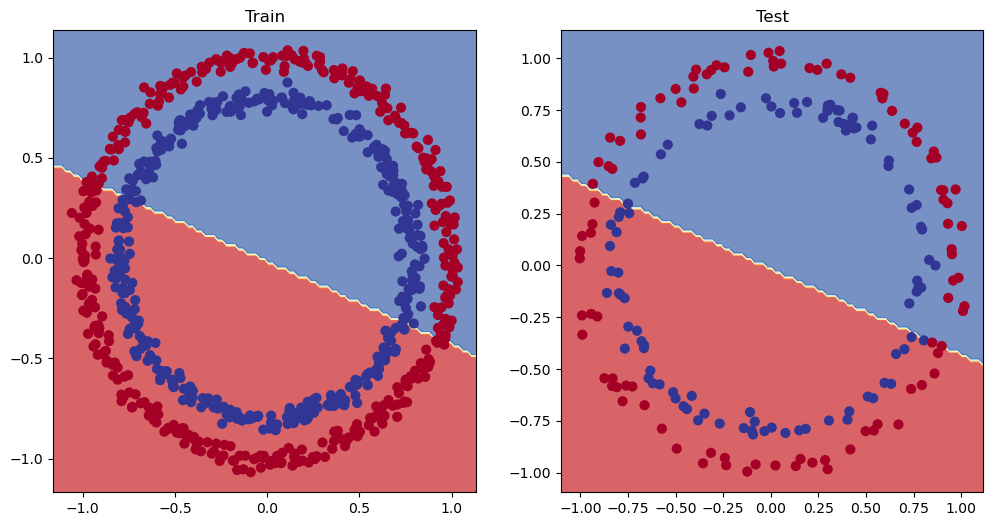

In [156]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Adding Non Linearity in Model

### Building Non Linear Model

In [185]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = CircleModelV2().to(device=device)
print(model_2)


CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [186]:
# Create Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an Optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [187]:
# Write a training and evaluation loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Train for longer

epochs = 1500


for epoch in range(epochs):
    
    ### Training    
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
          
    # Print out what's happening

    if epoch % 100 == 0:

        print(f"Epoch: {epoch}  |   Loss: {loss:.5f},   Acc: {acc:.2f}%  |   Test Loss: {test_loss:.5f},     Test Accuracy:  {test_acc:.2f}%")
 

Epoch: 0  |   Loss: 0.69295,   Acc: 50.00%  |   Test Loss: 0.69319,     Test Accuracy:  50.00%
Epoch: 100  |   Loss: 0.69115,   Acc: 52.88%  |   Test Loss: 0.69102,     Test Accuracy:  52.50%
Epoch: 200  |   Loss: 0.68977,   Acc: 53.37%  |   Test Loss: 0.68940,     Test Accuracy:  55.00%
Epoch: 300  |   Loss: 0.68795,   Acc: 53.00%  |   Test Loss: 0.68723,     Test Accuracy:  56.00%
Epoch: 400  |   Loss: 0.68517,   Acc: 52.75%  |   Test Loss: 0.68411,     Test Accuracy:  56.50%
Epoch: 500  |   Loss: 0.68102,   Acc: 52.75%  |   Test Loss: 0.67941,     Test Accuracy:  56.50%
Epoch: 600  |   Loss: 0.67515,   Acc: 54.50%  |   Test Loss: 0.67285,     Test Accuracy:  56.00%
Epoch: 700  |   Loss: 0.66659,   Acc: 58.38%  |   Test Loss: 0.66322,     Test Accuracy:  59.00%
Epoch: 800  |   Loss: 0.65160,   Acc: 64.00%  |   Test Loss: 0.64757,     Test Accuracy:  67.50%
Epoch: 900  |   Loss: 0.62362,   Acc: 74.00%  |   Test Loss: 0.62145,     Test Accuracy:  79.00%
Epoch: 1000  |   Loss: 0.56818, 

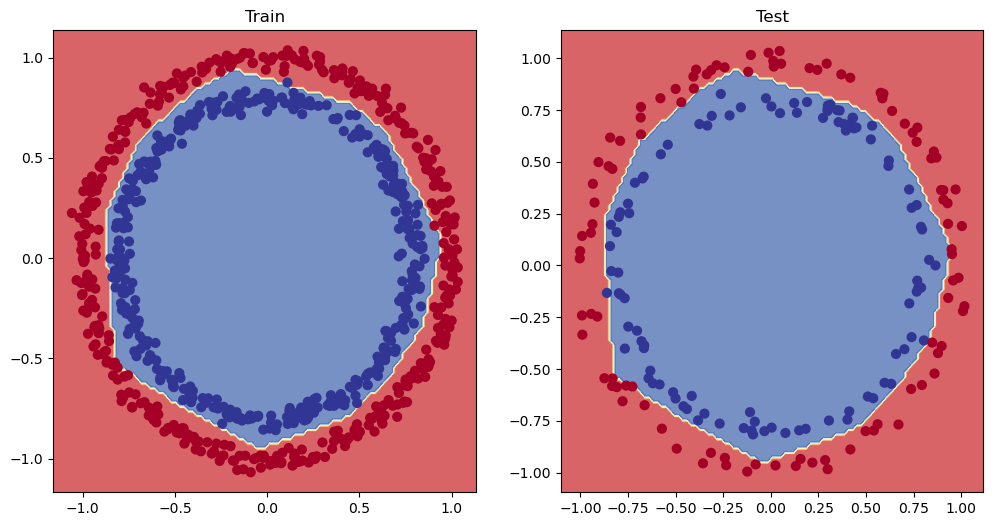

In [188]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)


# Multi class classification Problem

### Creating Dataset

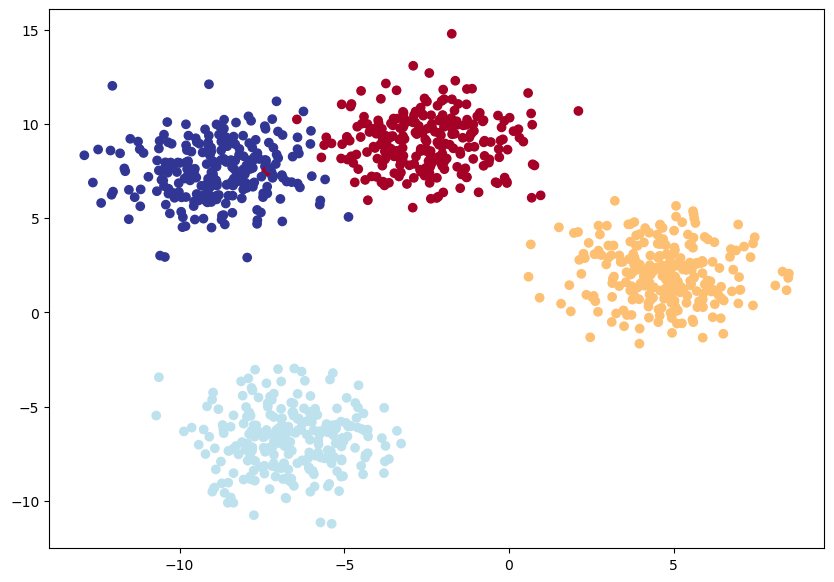

In [272]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparamters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create Multi class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

# 4. Plot data 
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [273]:
# Transferring data from CPU to GPU
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Building Model

In [274]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [275]:
# Build Classification Model
class BlobModel(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self,x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=2,
                        output_features=4,
                        hidden_units=8).to(device)

model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('linear_layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0

In [276]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [277]:
torch.unique(y_train)

tensor([0, 1, 2, 3], device='cuda:0')

## Create loss function and optimizer

In [278]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

## Getting Prediction Probabilities for Multi class model

In [279]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)

print(y_logits[:5])
print(y_test[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([1, 3, 2, 1, 0], device='cuda:0')


We need to convert the output into probabilities.
Logits -> Pred probs -> Pred labels

In [280]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)
    y_probs = torch.softmax(y_logits, dim=1)

print(y_probs[:5])
print(y_test[:5])

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor([1, 3, 2, 1, 0], device='cuda:0')


In [281]:
torch.sum(y_probs[0])

tensor(1., device='cuda:0')

In [282]:
torch.argmax(y_probs[0])

tensor(1, device='cuda:0')

In [283]:
y_pred = torch.argmax(y_probs, dim=1)
y_pred # Now the format look similar to the y_labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

## Creating Training and Testing loop

* Set Seed
* Set epoch and for loop
* Call train function
* Call model and send training data, forward pass
* Calculate loss
* Optimizer zero grad
* Loss backward
* Optimizer step
* Now evaluate, call eval function
* Call inference mode function
* Call model and send test data, forward pass
* Calculate loss and accuracy
* Print out whats happening

In [284]:
# Set Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epoch and for loop
epochs = 100

for epoch in range(epochs):

    # Call train function
    model_4.train()

    # Call model and send training data, forward pass
    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)


    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Now evaluate, call eval function
    model_4.eval()

    # Call inference mode function
    with torch.inference_mode():
        # Call model and send test data, forward pass
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out whats happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Accuracy: {acc:.2f}%     | Test Loss: {test_loss:.5f},    | Test Accuracy: {test_acc:.2f}%")


Epoch: 0  | Loss: 1.15883, Accuracy: 40.38%     | Test Loss: 1.07554,    | Test Accuracy: 48.00%
Epoch: 10  | Loss: 0.64476, Accuracy: 96.75%     | Test Loss: 0.66069,    | Test Accuracy: 97.50%
Epoch: 20  | Loss: 0.42535, Accuracy: 98.50%     | Test Loss: 0.43074,    | Test Accuracy: 100.00%
Epoch: 30  | Loss: 0.25294, Accuracy: 99.12%     | Test Loss: 0.24508,    | Test Accuracy: 99.50%
Epoch: 40  | Loss: 0.11232, Accuracy: 99.25%     | Test Loss: 0.10229,    | Test Accuracy: 99.50%
Epoch: 50  | Loss: 0.06627, Accuracy: 99.25%     | Test Loss: 0.05848,    | Test Accuracy: 99.50%
Epoch: 60  | Loss: 0.05068, Accuracy: 99.25%     | Test Loss: 0.04293,    | Test Accuracy: 99.50%
Epoch: 70  | Loss: 0.04300, Accuracy: 99.25%     | Test Loss: 0.03491,    | Test Accuracy: 99.50%
Epoch: 80  | Loss: 0.03836, Accuracy: 99.25%     | Test Loss: 0.02988,    | Test Accuracy: 99.50%
Epoch: 90  | Loss: 0.03525, Accuracy: 99.25%     | Test Loss: 0.02663,    | Test Accuracy: 99.50%


In [290]:
# Evaluate
model_4.eval()
with torch.inference_mode():
    test_logits = model_4(X_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
print(test_pred[:10])
print(y_test[:10])
print(test_pred == y_test)
print((test_pred == y_test).sum()) # Out of 200

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

Text(0.5, 1.0, 'Test')

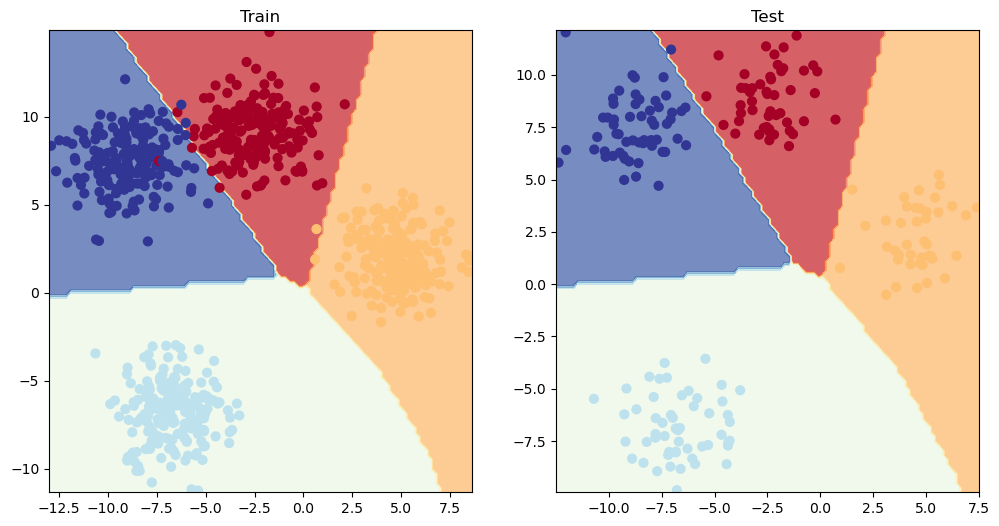

In [292]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_4,X_train,y_train)
plt.title("Train")
plt.subplot(1,2,2)
plot_decision_boundary(model_4,X_test,y_test)
plt.title("Test")

## Classification Metrics

* Accuracy - The proportion of correctly classified instances out of all instances.

    Formula: (TP+TN)/(TP+TN+FP+FN)
* Precision -  The proportion of correctly predicted positive instances out of all instances predicted as positive.

    Formula: TP/(TP+FP)
* Recall - The proportion of correctly predicted positive instances out of all actual positive instances.

    Formula: TP/(TP+FN)
* F1-score - The harmonic mean of Precision and Recall, balancing both metrics.

    Formula: 2∗(Precision∗Recall)/(Precision+Recall)
* Confusion Matrix - A table summarizing classification model performance by showing counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.
* Classification report - A text summary providing key classification metrics (Precision, Recall, F1-score, Support) for each class, along with overall averages.

In [300]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device=device)
torchmetric_accuracy(test_pred,y_test)

tensor(0.9950, device='cuda:0')